In [46]:
import os
from random import choice, seed
from tqdm import tqdm
import matplotlib.pyplot as plt 
import numpy as np
from collections import Counter

folder_name = "data/input/scripts_imsdb"
screenplay_name = choice(os.listdir(folder_name))

In [47]:
with open(os.path.join(folder_name, screenplay_name)) as f : 
    screenplay = f.read()
lines = screenplay.split("\n")

In [48]:
EMPTY_LINE_LABEL = "E"
SCENES_BOUNDARY_AND_DESCRIPTION_LABEL = "SN"
SCENES_BOUNDARY_LABEL = "S"
SCENES_DESCRIPTION_LABEL = "N"
CHARACTER_LABEL = "C"
DIALOGUE_LABEL = "D"
METADATA_LABEL = "M"

correspondance = {"E": "empty lines", "SN":"scenes (boundary and description)", "S":"scenes boundary", "N":"scenes description", "C":"character names", "D":"dialogues", "M":"metadata", "?":"unknown"}

In [49]:
CHARACTER_KEYWORDS = ["(O.S.)","(CONT'D)", "(0.S.)", "(O. S.)", "(0. S.)", "(V.O.)"]
BEGINNING_SCENES_KEYWORDS = ["EXT ", "EXT.", "INT ", "INT."]
ENDING_SCENES_KEYWORDS = ["FADE IN", "FADE INTO", "CUT TO", "DISSOLVE TO"]
META_KEYWORDS = ["(", ")"]
DIALOGUE_KEYWORDS = ["?"]

def get_indents_list(lines):
    indents = []
    for line in lines:
        len_line_with_no_left_spaces = len(line.lstrip())
        if len_line_with_no_left_spaces == 0 :  # the line only had spaces
            indents.append(-1)
        else : 
            indents.append(len(line) - len_line_with_no_left_spaces)
    return indents

def find_scenes(lines, beginning_scenes_keywords = BEGINNING_SCENES_KEYWORDS, end_scenes_keywords = ENDING_SCENES_KEYWORDS): 
    scenes = []
    current_scene = []
    for line in lines : 
        has_keyword = False
        for keyword in beginning_scenes_keywords + end_scenes_keywords : 
            if keyword in line : 
                if keyword in beginning_scenes_keywords : 
                    scenes.append(current_scene)
                    current_scene = [line]
                    has_keyword = True
                    break
                elif keyword in end_scenes_keywords : 
                    current_scene.append(line)
                    scenes.append(current_scene)
                    current_scene = []
                    has_keyword = True
                    break
        if not has_keyword : 
            current_scene.append(line)
    scenes.append(current_scene)
    return clean_scenes(scenes)

def clean_scenes(scenes):
    cleaned_scenes = []
    for scene in scenes : 
        if len(''.join(scene)) == 0 and len(cleaned_scenes) > 0 : 
            cleaned_scenes[-1] += scene
        else :     
            cleaned_scenes.append(scene)
    return cleaned_scenes

def occurences_keywords_in_groups(groups, keywords):
    groups_keyword_quantity = [0 for _ in range(len(groups))]
    for i, group in enumerate(groups) : 
        group_text = ''.join(group)
        for keyword in keywords:
            groups_keyword_quantity[i] += group_text.count(keyword)
    return groups_keyword_quantity

def frequency_capitalized_in_groups(groups):
    groups_upper_quantity = [0 for _ in range(len(groups))]
    for i, group in enumerate(groups) : 
        group_text = ''.join(group)
        total_letters = sum((letter.isupper() or letter.islower()) for letter in group_text)
        if total_letters != 0 : 
            groups_upper_quantity[i] += round(sum(letter.isupper() for letter in group_text)/total_letters, 2)
        else : 
            groups_upper_quantity[i] = 0
    return groups_upper_quantity

def mean_text_length_in_groups(groups):
    groups_text_length = []
    for i, group in enumerate(groups) : 
        groups_text_length.append(round(sum([len(line.lstrip()) for line in group])/len(group), 2))
    return groups_text_length

In [50]:
def print_several_lists(list_labels, lists):
    maximum_length = max([max([len(str(element)) for element in sublist]) for sublist in lists])
    for i, sublist in enumerate(lists):
        string = f"{list_labels[i]} : ["
        for element in sublist : 
            string += " " * (maximum_length - len(str(element))) + str(element) + ", "
        string += "]"
        print(string)

def characterize_indent_levels(lines, indents):
    indents_counter = Counter(indents)
    relevant_indent_levels = []
    for indent_level in indents_counter : 
        if indents_counter[indent_level] > 10 : 
            relevant_indent_levels.append(indent_level)
    groups = []
    for indent_level in relevant_indent_levels : 
        lines_idxs = np.where(np.array(indents) ==indent_level)[0]
        group_lines = [lines[lines_idxs[i]] for i in range(len(lines_idxs))]
        groups.append(group_lines)
    
    mean_text_lengths = mean_text_length_in_groups(groups)
    capitalized_frequency = frequency_capitalized_in_groups(groups)
    characters_keywords_occurences = occurences_keywords_in_groups(groups, CHARACTER_KEYWORDS)
    scenes_beginning_keywords_occurences = occurences_keywords_in_groups(groups, BEGINNING_SCENES_KEYWORDS)
    scenes_ending_keywords_occurences = occurences_keywords_in_groups(groups, ENDING_SCENES_KEYWORDS)
    meta_keywords_occurences = occurences_keywords_in_groups(groups, META_KEYWORDS)
    dialogues_keywords_occurences = occurences_keywords_in_groups(groups, DIALOGUE_KEYWORDS)
    
    
    result = {}

    for i, group in enumerate(groups) : 
        if relevant_indent_levels[i] == -1 : 
            result[relevant_indent_levels[i]] = EMPTY_LINE_LABEL
        elif characters_keywords_occurences[i] > 0 :
            result[relevant_indent_levels[i]] = CHARACTER_LABEL
        elif scenes_beginning_keywords_occurences[i] > 0 : 
            result[relevant_indent_levels[i]] = SCENES_BOUNDARY_AND_DESCRIPTION_LABEL
        elif scenes_ending_keywords_occurences[i]/len(group) > 0.8 : 
            result[relevant_indent_levels[i]] = SCENES_BOUNDARY_LABEL
        elif capitalized_frequency[i] > 0.9 and mean_text_lengths[i] < 10 :
            result[relevant_indent_levels[i]] = CHARACTER_LABEL
        elif meta_keywords_occurences[i] / len(group) > 1.0 : # usually two parenthesis per line, one is the minimum
            result[relevant_indent_levels[i]] = METADATA_LABEL
        elif dialogues_keywords_occurences[i] > 0 : 
            result[relevant_indent_levels[i]] = DIALOGUE_LABEL
        else : 
            result[relevant_indent_levels[i]] = "?"
    
    all_lists = [
        relevant_indent_levels, 
        result.values(),
        [len(group) for group in groups],
        characters_keywords_occurences,
        capitalized_frequency,
        mean_text_lengths,
        scenes_beginning_keywords_occurences,
        scenes_ending_keywords_occurences,
        meta_keywords_occurences,
        dialogues_keywords_occurences,
        ]
    print_several_lists(["I",  "R", "L", "C", "C", "L", "S", "S", "M", "D",], all_lists)

    return result

def tag_lines(list_lines, characterized_indent_levels):
    indents = get_indents_list(list_lines)
    tags = []
    for i, line in enumerate(list_lines):
        if (
            characterized_indent_levels[indents[i]]
            == SCENES_BOUNDARY_AND_DESCRIPTION_LABEL
        ):
            if frequency_capitalized_in_groups([line])[0] > 0.8:
                tags.append(SCENES_BOUNDARY_LABEL)
            else:
                tags.append(SCENES_DESCRIPTION_LABEL)
        else:
            tags.append(characterized_indent_levels[indents[i]])
    return tags

Found 222 scenes
Counter({10: 4188, -1: 2767, 25: 1073, 11: 63, 26: 25, 0: 4, 34: 2, 35: 1, 32: 1, 22: 1})
Syriana.txt


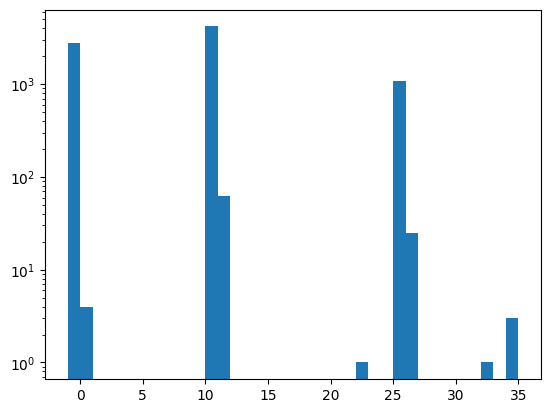

In [51]:
scenes = find_scenes(lines)
print(f"Found {len(scenes)} scenes")
indents = get_indents_list(lines)
if len(scenes) > 2:
    middle_indents = indents[len(scenes[0]) : -len(scenes[-1])]
    middle_lines = sum(scenes[1:-1], [])
else:
    middle_indents = indents
    middle_lines = lines
plt.hist(indents, bins = max(indents) + 1, log=True)

print(Counter(indents))
print(screenplay_name)

In [52]:
characterized_indent_levels = characterize_indent_levels(middle_lines, middle_indents)

I : [   10,    -1,    25,    26,    11, ]
R : [    C,     E,     C,     C,     C, ]
L : [ 4182,  2723,  1069,    25,    63, ]
C : [   70,     0,    86,    10,     9, ]
C : [ 0.14,     0,   1.0,   1.0,  0.24, ]
L : [34.72,   0.0,  8.61, 12.12, 36.78, ]
S : [  204,     0,     0,     0,     0, ]
S : [    6,     0,    82,     7,     0, ]
M : [  282,     0,   592,    28,    28, ]
D : [  213,     0,     0,     0,     0, ]


In [ ]:
for key, value in characterized_indent_levels.items():
    if value != EMPTY_LINE_LABEL:
        print(f"\n****** {correspondance[value].upper()} ******")
        lines_idxs = np.where(np.array(middle_indents) ==key)[0]
        for i in range(min(6, len(lines_idxs))):
            print(middle_lines[lines_idxs[i]])

: 